# Домашняя работа "Decision Trees"

In [5]:
# Imports
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

## Импорт данных

In [6]:
data = pd.read_csv('./data/credit_scoring_sample.csv', sep=";")

data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


Видим, что данные размечены и интересующая нас разметка содержится в колонке `SeriousDlqin2yrs`. Отделим этот столбец, и за одно разделим наш датасет на тренировочные и проверочные данные.


In [7]:
X = data.drop(["SeriousDlqin2yrs"], axis=1)
y = data["SeriousDlqin2yrs"].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42, stratify=y)

## EDA

Проверим на сколько сбалансированы наши классы.

In [8]:
y_train.value_counts()

0    28029
1     8021
Name: SeriousDlqin2yrs, dtype: int64

Классы несбалансированы.

Для начала посмотрим какие данные есть в нашем датасете.

In [9]:
X_train.head()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
33715,62,0,0.214561,0,1,9600.0,0.0
33663,39,1,0.191259,0,0,2310.0,0.0
10319,30,3,886.000000,0,0,0.0,1.0
1682,60,1,0.518785,0,2,1250.0,0.0
12117,61,0,0.366667,0,0,8729.0,0.0


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36050 entries, 33715 to 3132
Data columns (total 7 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   age                                   36050 non-null  int64  
 1   NumberOfTime30-59DaysPastDueNotWorse  36050 non-null  int64  
 2   DebtRatio                             36050 non-null  float64
 3   NumberOfTimes90DaysLate               36050 non-null  int64  
 4   NumberOfTime60-89DaysPastDueNotWorse  36050 non-null  int64  
 5   MonthlyIncome                         29139 non-null  float64
 6   NumberOfDependents                    35163 non-null  float64
dtypes: float64(3), int64(4)
memory usage: 2.2 MB


Видим, что колонке `MonthlyIncome` есть пропущенные данные, который нужно будет заполнить, либо выбросить.

In [11]:
X_train.describe()

,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
count,36050.000000,36050.000000,36050.000000,36050.000000,36050.000000,2.913900e+04,35163.000000
mean,51.214286,0.742497,354.088168,0.559029,0.494008,6.477622e+03,0.790831
std,14.643077,6.090541,2670.537041,6.077867,6.057482,1.378484e+04,1.132291
min,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,40.000000,0.000000,0.176631,0.000000,0.000000,3.289500e+03,0.000000
50%,51.000000,0.000000,0.372564,0.000000,0.000000,5.166000e+03,0.000000
75%,62.000000,0.000000,0.852013,0.000000,0.000000,8.000000e+03,1.000000
max,107.000000,98.000000,326442.000000,98.000000,98.000000,1.794060e+06,10.000000


Видно, что во всех колонках, кроме возраста есть выбросы, так как медиана отличается от максимального занчения на порядки.

age :


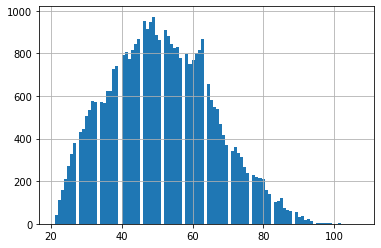

NumberOfTime30-59DaysPastDueNotWorse :


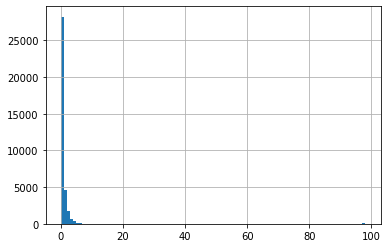

DebtRatio :


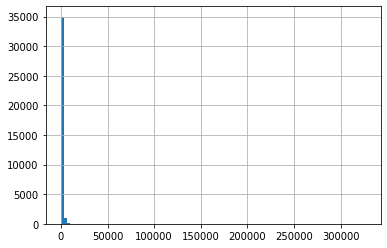

NumberOfTimes90DaysLate :


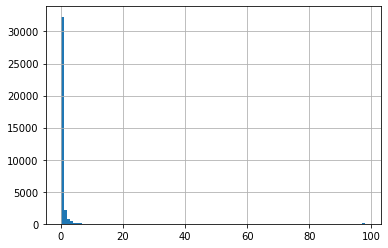

NumberOfTime60-89DaysPastDueNotWorse :


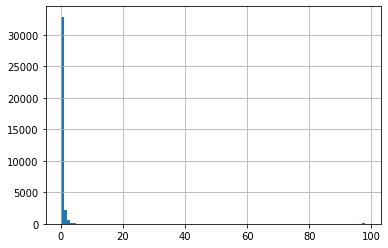

MonthlyIncome :


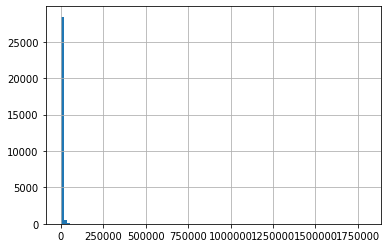

NumberOfDependents :


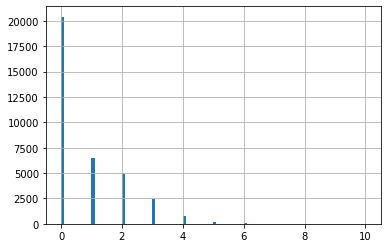

In [12]:
for col in X_train.columns:
    X_train[col].hist(bins=100)
    print(col, ":")
    plt.show()

Гистограмы распределений подтверждают выводы - есть выборсы.

Второе, что смутило, это регулярные пропуски в распределении возраста. Но учитывая, что мы строим модель на основе деревьев, это неважно.

## Подход к валидации

Для валидации мы используем K-Fold. Учитывая, что данные крайне несбалансированы, нам стоит выбрать метрику более устойичку к выброам, на пример `f1` или `rok_auc`. Мне сложно суди о том, какая метрива важна для конкретной задачи, этого нет в формулироваке. Поэтому я выберу `f1`. Хотя если подумать о сути, то наверно для банка лучше "не дать кретид тому, кто его может вернуть" чем "дать кредит тому, кто его не вернет". Если `positive` - это "дать кредит", то для банка важнее избежать FP-ошибок.

In [43]:
# Import metrics
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold

# Create K-Fold
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

## Построение модели

In [41]:
from sklearn.model_selection import GridSearchCV

# Clean data
X_train = X_train.fillna(X_train.median())

# decision tree model
dtree_model=DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
    'min_samples_leaf': [1,2,3,4,5,10,20]
}

dtree_gscv = GridSearchCV(dtree_model, param_grid, cv=skf, scoring="f1")

In [44]:
# fit model (DT)
dtree_gscv.fit(X_train, y_train)

print("Best estimator:", dtree_gscv.best_estimator_)
print("Best score:", dtree_gscv.best_score_)

Best estimator: DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=5, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')
Best score: 0.5702950099973032


## Визуализация дерева решений

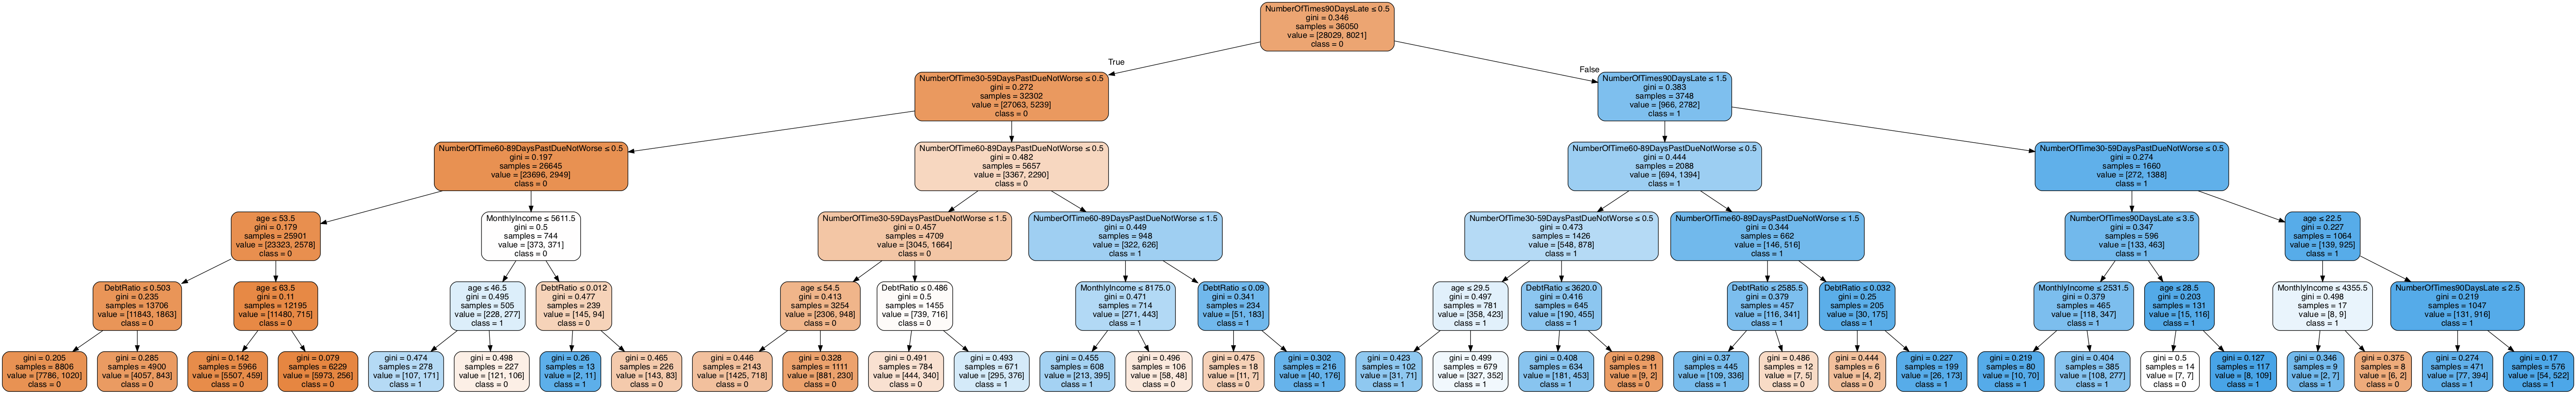

In [45]:
from sklearn.tree import export_graphviz
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

dot_data = StringIO()
export_graphviz(dtree_gscv.best_estimator_, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = X_train.columns,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('diabetes.png')
Image(graph.create_png())

## Валидация на тестовом набре

In [46]:
X_test = X_test.fillna(X_test.median())

#Predict the response for test dataset
y_pred = dtree_gscv.best_estimator_.predict(X_test)

Accuracy: 0.5525773195876288


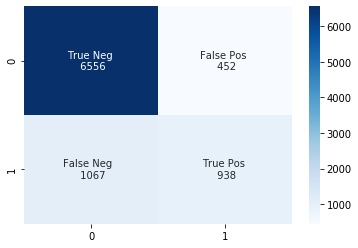

In [62]:
from sklearn.metrics import confusion_matrix

# Model Accuracy, how often is the classifier correct?
print("Accuracy:", f1_score(y_test, y_pred))

cf_matrix = confusion_matrix(y_test, y_pred)
labels = [f"True Neg \n {cf_matrix[0,0]}",f"False Pos \n {cf_matrix[0,1]}",f"False Neg  \n {cf_matrix[1,0]}",f"True Pos \n {cf_matrix[1,1]}"]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt="", cmap="Blues")